In [1]:
import networkx as nx
import networkx.algorithms.community as nx_comm

from utilities import import_networks

# from networkx.algorithms.community.centrality import girvan_newman
# from networkx.algorithms.community import lukes_partitioning

import matplotlib.pyplot as plt
import numpy as np

In [2]:
networks = import_networks()

print("\n".join([str(x) for x in networks]))

Graph with 1001 nodes and 75862 edges
Graph with 999 nodes and 75415 edges
Graph with 1025 nodes and 80306 edges
Graph with 1018 nodes and 80077 edges


# Modularity network classification

## Finding Communities
---

In [142]:
from networkx.algorithms.community import greedy_modularity_communities

In [161]:
%%time
# Obtain modularity communities
resolution = 1
modularity_communities = [list(greedy_modularity_communities(g,weight='weight',resolution = resolution)) for g in networks]
for comm in modularity_communities:
    print(f"{len(comm)} communities: {[len(x) for x in comm]}")

7 communities: [335, 223, 126, 124, 85, 82, 26]
7 communities: [332, 217, 134, 123, 83, 83, 27]
8 communities: [328, 199, 141, 140, 84, 82, 27, 24]
8 communities: [268, 197, 167, 165, 93, 81, 28, 19]
CPU times: user 26.1 s, sys: 3.88 ms, total: 26.1 s
Wall time: 26.1 s


In [162]:
#Modularity scores:
modularity_scores = [nx_comm.modularity(g,comm,weight="weight") for g,comm in zip(networks,modularity_communities)]
print(modularity_scores)

partition_quality = [nx_comm.partition_quality(g,comm) for g,comm in zip(networks,modularity_communities)]
print(partition_quality)

[0.5853419848395155, 0.5744591553335524, 0.6081425839562082, 0.6073114146403099]
[(0.5304632095120086, 0.8026113886113886), (0.5176025989524631, 0.800806818842891), (0.4992155007097851, 0.8085194359756097), (0.4758295140926858, 0.8176133433014008)]


## Test resolution parameter

In [ ]:
# Obtain modularity communities
def get_modullarity_communities(G:nx.Graph,resolution=1,result = None,year = None):
    modularity_communities = [list(greedy_modularity_communities(g,weight='weight',resolution = r)) for r in resolution] 
    if result is not None:
        result[year] = modularity_communities
    return(modularity_communities)

In [ ]:
%%time
communities_by_resolution =  {}
resulutions = np.arange(0,1,0.1)
resolutions = np.append(np.arange(0,1,0.2),np.arange(1,25,0.5))
print(resolutions)
for g,year in zip(networks,range(2018,2022)):
    communities_by_resolution[year] = [[list(x) for x in y] for y in get_modullarity_communities(g,resolution=resolutions)]

In [34]:
#Classify Communities
communities_statistics = {}
for (year,comms),g,r in  zip(communities_by_resolution.items(),networks,resolutions):
    communities_statistics[year] = {"N_communities":    [len(x) for x in comms],
                                    "Avg_comm_size":    [np.average([len(y) for y in x]) for x in comms],
                                    "Sigma_comm_size":  [np.std([len(y) for y in x]) for x in comms],
                                    "Median_comm_size": [np.median([len(y) for y in x]) for x in comms],
                                    "Modularity_score": [nx_comm.modularity(g,c,resolution=r,weight='weight') for c in comms]}

In [ ]:
# Export Data
import json
with open("data/modularity_communities.json", "w") as f:
    json.dump(communities_by_resolution,f)
with open("data/modularity_communities_statistics.json", "w") as f:
    json.dump(communities_statistics,f)

## Visualize Data
---

In [3]:
#Import data
import json
with open("data/modularity_communities_statistics.json", "r") as f:
    communities_statistics = json.load(f)
with open("data/modularity_communities.json", "r") as f:
    communities_by_resolution = json.load(f)

resolutions = np.append(np.arange(0,1,0.2),np.arange(1,25,0.5))

/tmp/ipykernel_22307/1572019614.py:30: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  a.set(xlim=(0,20),ylim=(0,a.get_ylim()[1]))


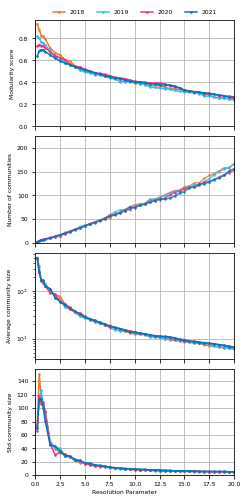

In [35]:
#Visualize statistics
colors = ['#EE7732', '#33BBEE',  '#EE3377',  '#0077BB']
colors = dict(zip(range(2018,2022),colors))

plt.rcParams.update({'font.size': 6})
plt.rc('xtick', labelsize=6)    # fontsize of the tick labels
plt.rc('ytick', labelsize=6)    
plt.rc('axes', titlesize=6)    


cm = 1/2.54
fig,ax = plt.subplots(ncols=1,nrows=4,figsize=(8.7*cm,2*8.7*cm),sharex=True)
fig.text(0.5, 0.00, 'Resolution Parameter', ha='center')

ax[0].set(ylabel="Modularity score",yscale="linear")
ax[1].set(ylabel="Number of communities")
# # ax[0,1].set(xlabel="Resolution parameter", ylabel="Median community size")
ax[2].set( ylabel="Average community size",yscale="log")
ax[3].set( ylabel="Std community size",yscale="linear")
for year, data in communities_statistics.items():
    ax[0].plot(resolutions[1:],data["Modularity_score"][1:],label=year, marker='o', ms=1.5, color = colors[int(year)])
    ax[1].plot(resolutions[1:],data["N_communities"][1:],label=year, marker='o', ms=1.5,alpha=0.8, color = colors[int(year)])
    # ax[0,1].plot(resolutions,data["Median_comm_size"],label=year, marker='o', ms=3, color = colors[int(year)])
    ax[2].plot(resolutions[1:],data["Avg_comm_size"][1:],label=year, marker='o', ms=1.5, color = colors[int(year)])
    ax[3].plot(resolutions[1:],data["Sigma_comm_size"][1:],label=year, marker='o', ms=1.5, color = colors[int(year)])
             

for a in ax.flatten():
    a.grid()
    a.set(xlim=(0,20),ylim=(0,a.get_ylim()[1]))
    # a.set_xticks(a.get_xticks())
    # a.set_xticklabels(a.get_xticklabels(),fontdict={"fontsize":6})
    # a.legend()
# ax[0,0].grid()
# ax[0,1].grid()
ax[0].legend(ncol=4,bbox_to_anchor=(0.5,1),loc="lower center",frameon=False)
# ax[0,1].legend()
plt.tight_layout()
plt.savefig("modularity_community_statistics.pdf")
# plt.savefig("modularity_community_statistics.png",dpi=200)

In [30]:
resolutions

array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,
        4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,
        9.5, 10. , 10.5, 11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5,
       15. , 15.5, 16. , 16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. ,
       20.5, 21. , 21.5, 22. , 22.5, 23. , 23.5, 24. , 24.5])

In [32]:
from scipy.stats import linregress

fits = []
for year, data in communities_statistics.items():
    fits.append(linregress(resolutions, data["N_communities"]))
    print(fits[-1])
    print(data["Modularity_score"])
    

LinregressResult(slope=8.521685017418092, intercept=-5.968200013107705, rvalue=0.9977282667905746, pvalue=1.9850296483905756e-61, stderr=0.08057030057391867, intercept_stderr=1.1126343888063044)
[0.0, 0.42594033576037416, 0.5281953837505108, 0.5803850109682843, 0.582151106583839, 0.5853419848395155, 0.5764297195024911, 0.5683549669298386, 0.5610864952977456, 0.5384659035472172, 0.5309415985579653, 0.5011588042709199, 0.47377944927749516, 0.46804460866867104, 0.45956566856728526, 0.4517191605016122, 0.44491972131294827, 0.43178526809951817, 0.423327612879073, 0.4172307258204598, 0.41088414956548475, 0.3975760764567171, 0.38819623438100115, 0.3776688925069504, 0.37032955012104124, 0.37005037132497076, 0.3552662380112231, 0.3554549374274474, 0.35139140044394274, 0.34217453009722365, 0.32898251710450005, 0.3253929129283122, 0.32274690506544357, 0.3129214495804596, 0.3106852598738318, 0.29917337020042895, 0.29533192590005797, 0.2818095754268471, 0.27746466988827556, 0.2551987406404693, 0.24

In [ ]:
from scipy.stats import norm

In [ ]:
fig,ax = plt.subplots(figsize=(10,5))
ax.set(xlabel="Community size", ylabel="p")

x = np.linspace(0,150,200)
for average,std in zip(communities_statistics[2018]["Avg_comm_size"],communities_statistics[2018]["Sigma_comm_size"]):
    ax.plot(x,norm(loc=average,scale=std).pdf(x),label=year, marker='',ls='-', ms=3)
             
ax.grid()
# ax.legend()

53

In [ ]:
g = networks[0]
comm = [[g.nodes[y]["name"] for y in x] for x in communities_by_resolution["2018"][6]]
print(comm[2])
print()
print(comm[3])

areas_in_comm = []
for a in comm:
    unique = list(set(a))
    areas_in_comm.append({area: a.count(area) for area in unique})
    # print(a)
print(areas_in_comm)
print()

In [55]:
# Find matching communities
def enumerate_simmilarity(d1,d2):
    scores = []
    simmilarity = lambda d,d1: len(d1.keys() & d.keys()) * sum([d1[c]*d[c]/(1+abs(d1[c]-d[c])) for c in (d1.keys() & d.keys())])
    for d in d1:
        scores.append([simmilarity(d,dd) for dd in d2])
        
    scores = np.array(scores,dtype=float)
    best = np.full(len(d1),-1)
        
    for i in range(len(d1)):
        index = np.unravel_index(scores.argmax(),scores.shape)
        best[index[0]] = index[1]
        scores[index[0]] = -1
        scores[:,index[1]] = -1
     
    return list(zip(best,d1))

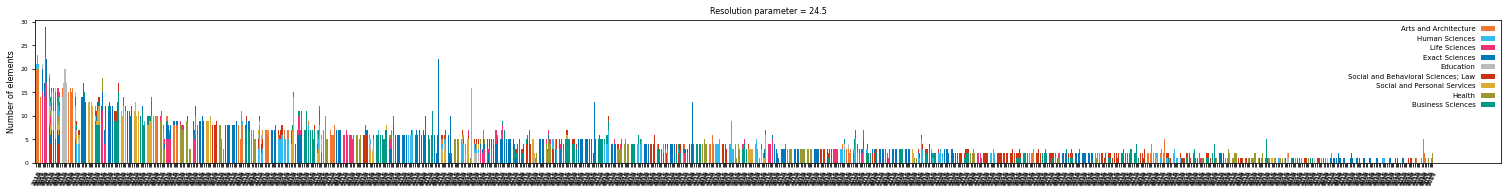

In [62]:
colors = ['#BBBBBB', '#EE7732', '#33BBEE', '#CC3311', '#009988', '#EE3377',  '#0077BB','#DDAA33', '#999933']
areas  = ['Educação', 'Artes e Arquitetura',
          'Humanidades', 'Direito, Ciências Sociais e do Comportamento', 'Ciências Empresariais', 
          'Ciências da Vida', 'Ciências Exatas', 'Serviços Sociais e Pessoais', 'Saúde']
areas_en  = ['Education', 'Arts and Architecture',
          'Human Sciences', 'Social and Behavioral Sciences; Law', 'Business Sciences', 
          'Life Sciences', 'Exact Sciences', 'Social and Personal Services', 'Health']
areas_en=dict(zip(areas,areas_en))
area_colors = dict(zip(areas,colors))
# plt.rcparams()
plt.rcParams.update({'font.size': 9})


x0 = 0

cm = 1/2.54
fig,ax = plt.subplots(figsize=(3*17.8*cm,7*cm))

resolution_index = -1
areas_in_comm = []
for n, G in enumerate(networks):
    comm = [[G.nodes[y]["area"] for y in x] for x in communities_by_resolution[str(G.graph["year"])][resolution_index]]
    areas_in_comm.append([{area: a.count(area) for area in list(set(a))} for a in comm])
    
max_idx = areas_in_comm.index(max(areas_in_comm, key = len))
max_comms = max(areas_in_comm, key = len)
max_comms_enum = list(enumerate(max_comms))

for i in range(0,4):
    if i == max_idx: 
        areas_in_comm[i] = max_comms_enum
        continue
    areas_in_comm[i] = enumerate_simmilarity(areas_in_comm[i], max_comms)
    
for n, (G,areas_year) in enumerate(zip(networks,areas_in_comm)):
    y_offset = 0
    for i,area in areas_year:
        y_offset = 0
        parts = list(area.items())
        parts.sort(reverse=True,key = lambda x: x[1])
        for j,(a,count) in enumerate(parts):
            ax.bar(x0 + i*5+n,count,bottom=y_offset,color=area_colors[a],label=areas_en[a])
            y_offset += count

years = list(range(2018,2022))*len(max_comms)
idx = [x0 + i*5 + j for i in range(len(max_comms)) for j in range(4)]        
            
ax.set_xticks(idx)
ax.set_xticklabels(years, rotation=65, fontdict={"fontsize":6})

ax.set(xlim=(-1,ax.get_xlim()[1]-1))

ax.set_title(f"Resolution parameter = {resolutions[resolution_index]}", fontdict={"fontsize":8})

ax.set_ylabel(f"Number of elements", fontdict={"fontsize":8})
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1,1), loc="upper right",
            fontsize=7, markerfirst=False, frameon=False)

plt.tight_layout()
plt.savefig("comm.pdf")
# plt.savefig("comm.jpeg",dpi=200)

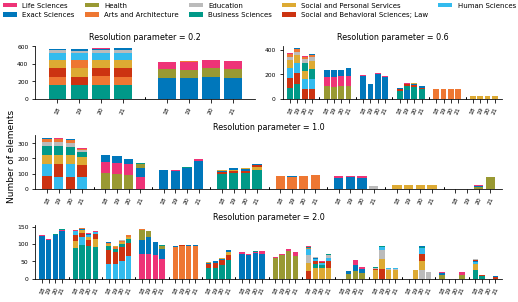

In [61]:
colors = ['#BBBBBB', '#EE7732', '#33BBEE', '#CC3311', '#009988', '#EE3377',  '#0077BB','#DDAA33', '#999933']
areas  = ['Educação', 'Artes e Arquitetura',
          'Humanidades', 'Direito, Ciências Sociais e do Comportamento', 'Ciências Empresariais', 
          'Ciências da Vida', 'Ciências Exatas', 'Serviços Sociais e Pessoais', 'Saúde']
areas_en  = ['Education', 'Arts and Architecture',
          'Human Sciences', 'Social and Behavioral Sciences; Law', 'Business Sciences', 
          'Life Sciences', 'Exact Sciences', 'Social and Personal Services', 'Health']
areas_en=dict(zip(areas,areas_en))
area_colors = dict(zip(areas,colors))
# plt.rcparams()
plt.rcParams.update({'font.size': 9})


x0 = 0

cm = 1/2.54
# fig,axes = plt.subplots(nrows=5, figsize=(17.8*cm,5*4*cm))

mosaic = """
AB
CC
DD
"""
fig = plt.figure(constrained_layout=False, figsize=(17.8*cm,3*3.5*cm))
ax_dict = fig.subplot_mosaic(mosaic)

# resolution_index = 9
for ax,resolution_index in zip(ax_dict.values(),[1,3,5,7]):
    areas_in_comm = []
    for n, G in enumerate(networks):
        comm = [[G.nodes[y]["area"] for y in x] for x in communities_by_resolution[str(G.graph["year"])][resolution_index]]
        areas_in_comm.append([{area: a.count(area) for area in list(set(a))} for a in comm])

    max_idx = areas_in_comm.index(max(areas_in_comm, key = len))
    max_comms = max(areas_in_comm, key = len)
    max_comms_enum = list(enumerate(max_comms))

    for i in range(0,4):
        if i == max_idx: 
            areas_in_comm[i] = max_comms_enum
            continue
        areas_in_comm[i] = enumerate_simmilarity(areas_in_comm[i], max_comms)

    for n, (G,areas_year) in enumerate(zip(networks,areas_in_comm)):
        y_offset = 0
        for i,area in areas_year:
            y_offset = 0
            parts = list(area.items())
            parts.sort(reverse=True,key = lambda x: x[1])
            for j,(a,count) in enumerate(parts):
                ax.bar(x0 + i*5+n,count,bottom=y_offset,color=area_colors[a],label=areas_en[a])
                y_offset += count

    years = list(range(18,22))*len(max_comms)
    idx = [x0 + i*5 + j for i in range(len(max_comms)) for j in range(4)]        
    idx_minor = [x0 + i*5 + 4 for i in range(len(max_comms)-1) for j in range(4)]        

    ax.set_xticks(idx_minor,minor=True)
    ax.set_xticks(idx,minor=False)
    ax.tick_params(which="minor",axis="x",direction="in")
    ax.set_xticklabels(years, rotation=65, fontdict={"fontsize":6})

    ax.set(xlim=(-1,idx[-1]+1))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


    ax.set_title(f"Resolution parameter = {resolutions[resolution_index]:.1f}", fontdict={"fontsize":8})

# axes[1].set_ylabel(f"Number of elements", fontdict={"fontsize":8})
fig.text(0.0, 0.50, 'Number of elements', va='center',ha='left',rotation=90)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

fig.legend(by_label.values(), by_label.keys(), ncol = 5,loc="upper left", #bbox_to_anchor=(0,1.1), 
            fontsize=7, markerfirst=True, frameon=False,  borderaxespad=0,mode="expand")

plt.tight_layout()
plt.subplots_adjust(top=0.87)
plt.savefig("images/modularity_communities_by_field.pdf")
# plt.savefig("comm.jpeg",dpi=200)


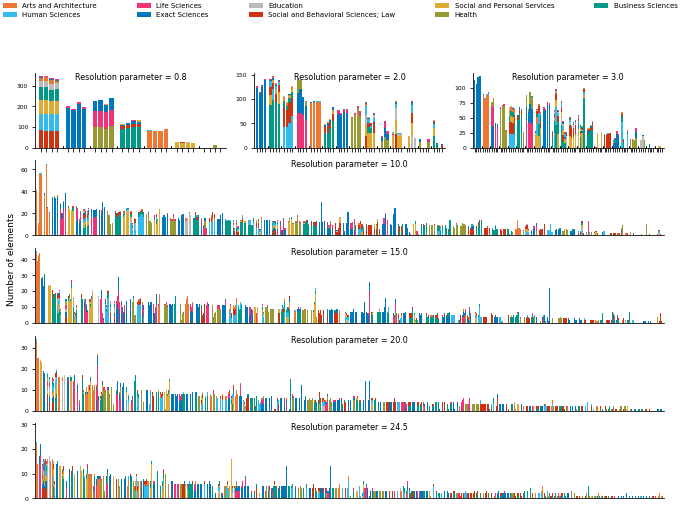

In [73]:
colors = ['#BBBBBB', '#EE7732', '#33BBEE', '#CC3311', '#009988', '#EE3377',  '#0077BB','#DDAA33', '#999933']
areas  = ['Educação', 'Artes e Arquitetura',
          'Humanidades', 'Direito, Ciências Sociais e do Comportamento', 'Ciências Empresariais', 
          'Ciências da Vida', 'Ciências Exatas', 'Serviços Sociais e Pessoais', 'Saúde']
areas_en  = ['Education', 'Arts and Architecture',
          'Human Sciences', 'Social and Behavioral Sciences; Law', 'Business Sciences', 
          'Life Sciences', 'Exact Sciences', 'Social and Personal Services', 'Health']
areas_en=dict(zip(areas,areas_en))
area_colors = dict(zip(areas,colors))

plt.rcParams.update({'font.size': 9})

x0 = 0


mosaic = """
ABC
DDD
EEE
FFF
GGG
"""
cm = 1/2.54
fig = plt.figure(constrained_layout=False, figsize=(23.5*cm,17.8*cm))
ax_dict = fig.subplot_mosaic(mosaic)

for ax,resolution_index in zip(ax_dict.values(),[4,7,9,23,33,43,52]):
    areas_in_comm = []
    for n, G in enumerate(networks):
        comm = [[G.nodes[y]["area"] for y in x] for x in communities_by_resolution[str(G.graph["year"])][resolution_index]]
        areas_in_comm.append([{area: a.count(area) for area in list(set(a))} for a in comm])

    max_idx = areas_in_comm.index(max(areas_in_comm, key = len))
    max_comms = max(areas_in_comm, key = len)
    max_comms_enum = list(enumerate(max_comms))

    for i in range(0,4):
        if i == max_idx: 
            areas_in_comm[i] = max_comms_enum
            continue
        areas_in_comm[i] = enumerate_simmilarity(areas_in_comm[i], max_comms)

    for n, (G,areas_year) in enumerate(zip(networks,areas_in_comm)):
        y_offset = 0
        for i,area in areas_year:
            y_offset = 0
            parts = list(area.items())
            parts.sort(reverse=True,key = lambda x: x[1])
            for j,(a,count) in enumerate(parts):
                ax.bar(x0 + i*5+n,count,bottom=y_offset,color=area_colors[a],label=areas_en[a])
                y_offset += count

    if resolution_index < 10:
        years = list(range(18,22))*len(max_comms)
        idx = [x0 + i*5 + j for i in range(len(max_comms)) for j in range(4)]        
        idx_minor = [x0 + i*5 + 4 for i in range(len(max_comms)-1) for j in range(4)]        
        ax.set_xticks(idx_minor,minor=True)
        ax.set_xticks(idx,minor=False)
        ax.tick_params(which="minor",axis="x",direction="in")
        ax.set_xticklabels([""]*len(idx), rotation=65, fontdict={"fontsize":6})
    else:
        years = list(range(18,22))*len(max_comms)
        idx = [x0 + i*5 + j for i in range(len(max_comms)) for j in range(4)]        
        idx_minor = [x0 + i*5 + 4 for i in range(len(max_comms)-1) for j in range(4)]        
        ax.set_xticks([],minor=False)
        ax.set_xticklabels([], rotation=65, fontdict={"fontsize":6})


    ax.set(xlim=(-1,idx[-1]+1))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


    ax.text(0.5,1,f"Resolution parameter = {resolutions[resolution_index]:.1f}", fontsize=8,transform=ax.transAxes,va="top",ha="center")

# axes[1].set_ylabel(f"Number of elements", fontdict={"fontsize":8})
fig.text(0.0, 0.50, 'Number of elements', va='center',ha='left',rotation=90)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

fig.legend(by_label.values(), by_label.keys(), ncol = 5,loc="upper left", #bbox_to_anchor=(0,1.1), 
            fontsize=7, markerfirst=True, frameon=False,  borderaxespad=0,mode="expand")

plt.tight_layout()
plt.subplots_adjust(top=0.87)
plt.savefig("images/modularity_communities_by_field_extra.pdf",orientation='landscape')
# plt.savefig("comm.jpeg",dpi=200)


**Dimensoes TeX: 17.8 x 23.5**

# Cities

In [220]:
cities = list(set([n["faculty_name"].split(":")[0].replace("Universidade","").replace("Instituto Politécnico","") for _,n in networks[0].nodes(data=True)]))

In [221]:
cities = [" ".join([x for x in c.split(" ") if not x.startswith("d") and len(x)>4]) for c in cities]

In [222]:
cities

['Trás-os-Montes Douro',
 'Setúbal',
 'Leiria',
 'Bragança',
 'Escola Superior Enfermagem Porto',
 'Tomar',
 'Beira Interior',
 'Santarém',
 'Escola Superior Hotelaria Turismo Estoril',
 'Lisboa',
 'Lisboa',
 'Évora',
 'Porto',
 'Escola Superior Enfermagem Coimbra',
 'Viana Castelo',
 'Escola Superior Enfermagem Lisboa',
 'Guarda',
 'Coimbra',
 'Cávado',
 'ISCTE',
 'Escola Superior Náutica Infante Henrique',
 '',
 'Castelo Branco',
 'Viseu',
 'Madeira',
 'Minho',
 'Algarve',
 'Aveiro',
 'Açores',
 'Portalegre']

In [ ]:
['Trás-os-Montes',
 'Setúbal',
 'Leiria',
 'Bragança',
 'Tomar',
 'Beira Interior',
 'Santarém',
 'Escola Superior Hotelaria Turismo Estoril',
 'Lisboa',
 'Lisboa',
 'Évora',
 'Porto',
 'Escola Superior Enfermagem Coimbra',
 'Viana Castelo',
 'Escola Superior Enfermagem Lisboa',
 'Guarda',
 'Coimbra',
 'Cávado',
 'ISCTE',
 'Escola Superior Náutica Infante Henrique',
 '',
 'Castelo Branco',
 'Viseu',
 'Madeira',
 'Minho',
 'Algarve',
 'Aveiro',
 'Açores',
 'Portalegre']

In [223]:
list(set([n["faculty_name"] for _,n in networks[0].nodes(data=True)]))

['Universidade de Coimbra: Faculdade de Farmácia',
 'Instituto Politécnico de Beja: Escola Superior de Educação',
 'Universidade de Trás-os-Montes e Alto Douro: Escola de Ciências e Tecnologia',
 'Universidade do Porto: Faculdade de Engenharia',
 'Universidade de Lisboa: Instituto Superior Técnico',
 'Universidade do Porto: Faculdade de Psicologia e de Ciências da Educação',
 'Instituto Politécnico de Coimbra: Escola Superior de Tecnologia e Gestão de Oliveira do Hospital',
 'Universidade do Algarve',
 'Universidade de Aveiro',
 'Universidade do Minho: Escola Superior de Enfermagem',
 'Escola Superior de Enfermagem do Porto',
 'Instituto Politécnico de Coimbra: Escola Superior Agrária de Coimbra',
 'Instituto Politécnico de Portalegre: Escola Superior de Tecnologia e Gestão',
 'Universidade de Lisboa: Faculdade de Farmácia',
 'Universidade de Coimbra: Faculdade de Letras',
 'Instituto Politécnico de Castelo Branco: Escola Superior de Gestão de Idanha-a-Nova',
 'Universidade do Porto: F

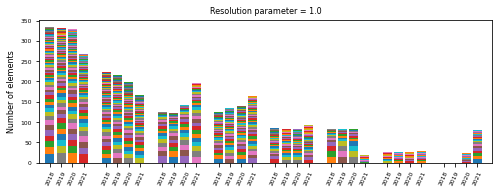

In [225]:
colors = ['#BBBBBB', '#EE7732', '#33BBEE', '#CC3311', '#009988', '#EE3377',  '#0077BB','#DDAA33', '#999933']
# areas  = ['Educação', 'Artes e Arquitetura',
          # 'Humanidades', 'Direito, Ciências Sociais e do Comportamento', 'Ciências Empresariais', 
          # 'Ciências da Vida', 'Ciências Exatas', 'Serviços Sociais e Pessoais', 'Saúde']
# areas_en  = ['Education', 'Arts and Architecture',
          # 'Human Sciences', 'Social and Behavioral Sciences; Law', 'Business Sciences', 
          # 'Life Sciences', 'Exact Sciences', 'Social and Personal Services', 'Health']
# areas_en=dict(zip(areas,areas_en))
# area_colors = dict(zip(areas,colors))
# plt.rcparams()
plt.rcParams.update({'font.size': 9})


x0 = 0

cm = 1/2.54
fig,ax = plt.subplots(figsize=(17.8*cm,7*cm))

resolution_index = 5
areas_in_comm = []
for n, G in enumerate(networks):
    comm = [[G.nodes[y]["faculty_name"] for y in x] for x in communities_by_resolution[str(G.graph["year"])][resolution_index]]
    areas_in_comm.append([{area: a.count(area) for area in list(set(a))} for a in comm])
    
max_idx = areas_in_comm.index(max(areas_in_comm, key = len))
max_comms = max(areas_in_comm, key = len)
max_comms_enum = list(enumerate(max_comms))

for i in range(0,4):
    if i == max_idx: 
        areas_in_comm[i] = max_comms_enum
        continue
    areas_in_comm[i] = enumerate_simmilarity(areas_in_comm[i], max_comms)
    
for n, (G,areas_year) in enumerate(zip(networks,areas_in_comm)):
    y_offset = 0
    for i,area in areas_year:
        y_offset = 0
        parts = list(area.items())
        parts.sort(reverse=True,key = lambda x: x[1])
        for j,(a,count) in enumerate(parts):
            ax.bar(x0 + i*5+n,count,bottom=y_offset)
            y_offset += count

years = list(range(2018,2022))*len(max_comms)
idx = [x0 + i*5 + j for i in range(len(max_comms)) for j in range(4)]        
            
ax.set_xticks(idx)
ax.set_xticklabels(years, rotation=65, fontdict={"fontsize":6})

ax.set(xlim=(-1,ax.get_xlim()[1]-1))

ax.set_title(f"Resolution parameter = {resolutions[resolution_index]}", fontdict={"fontsize":8})

ax.set_ylabel(f"Number of elements", fontdict={"fontsize":8})
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1,1), loc="upper right",
            fontsize=7, markerfirst=False, frameon=False)

plt.tight_layout()
plt.savefig("comm.pdf")
# plt.savefig("comm.jpeg",dpi=200)
